# Dataset

In [6]:
import zipfile

!wget https://chitanka.info/text/4618-frankenshtajn.txt.zip

path = "4618-frankenshtajn.txt.zip"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(".")
    
!mv "Mary-Shelley -  - . Frankenshtajn - 4618.txt" "dataset.txt"

!rm $path


--2024-09-23 12:40:58--  https://chitanka.info/text/4618-frankenshtajn.txt.zip
Resolving chitanka.info (chitanka.info)... 2a06:98c1:3121::2, 2a06:98c1:3120::2, 188.114.96.2, ...
Connecting to chitanka.info (chitanka.info)|2a06:98c1:3121::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename= [following]
--2024-09-23 12:40:58--  https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename=
Resolving m3.chitanka.info (m3.chitanka.info)... 2a06:98c1:3120::2, 2a06:98c1:3121::2, 188.114.97.2, ...
Connecting to m3.chitanka.info (m3.chitanka.info)|2a06:98c1:3120::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip [following]
--2024-09-23 12:40:58--  https://m3.chitanka.info/cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip
Reusing existing connection to [m3.chitanka.info]:443.
HTTP request sent, awaiting respon

In [7]:
with open("dataset.txt", "r") as f:
    text = f.read()

# Vocabulary

In [8]:
unique_chars = set(text)
sorted_chars = sorted(unique_chars)
sorted_chars
"".join(sorted_chars)

'\t\n !$()*,-./0123456789:;=?DIMNVX[]_abcdefghijkmnoprstuvx«»АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЮЯабвгдежзийклмнопрстуфхцчшщъьюя–—“„…\ufeff'

# Tokenizer

In [9]:
encoding = { c: i for i, c in enumerate(sorted_chars) }

def encode(text: str):
    return [encoding[c] for c in text]

def test_encode():
    test_text = "франкейщайн!"
    test_encoding = encode(test_text)
    assert test_encoding[0] == encoding[test_text[0]]
    assert test_encoding[1] == encoding[test_text[1]]
    
# test_encode()

decoding = { i: c for i, c in enumerate(sorted_chars) }

test_text = "франкейщайн!"
test_encoding = encode(test_text)

def decode(arr):
    return "".join([decoding[t] for t in arr])

def test_decode():
    test_text = "франкейщайн!"
    assert decode(encode(test_text)) == test_text
    
# test_decode()

In [10]:
import torch

data = torch.tensor(encode(text))

data

tensor([120,   0,  69,  ...,  13,   1,   1])

In [11]:
train_data_size = round(len(data) * 0.9)

train_data = data[:train_data_size]

train_data

tensor([120,   0,  69,  ..., 102,  95,  99])

In [12]:
val_data = data[train_data_size:]

val_data

tensor([103,  99,   2,  ...,  13,   1,   1])

# Model input and output (output = input[last + 1])

In [13]:
context_length = 8

train_data[:context_length+1]

tensor([120,   0,  69,  90, 101,  93,   2,  81,  90])

In [14]:
model_input = train_data[:context_length]

model_input

tensor([120,   0,  69,  90, 101,  93,   2,  81])

In [15]:
decode(model_input.numpy().tolist())

'\ufeff\tМери Ш'

In [16]:
model_output = train_data[1:context_length+1]

model_output[-1]

tensor(90)

In [17]:
decode(model_output.numpy().tolist())[-1]

'е'

# Batch

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_batch(split: str, batch_size: int, context_length: int):
    batch_data = train_data if split == "train" else val_data
    ix = torch.randint(len(batch_data) - context_length, (batch_size,))

    x = torch.stack([batch_data[i:i+context_length] for i in ix])
        
    y = torch.stack([batch_data[i+1:i+context_length+1] for i in ix])
    
    x, y = x.to(device), y.to(device)
    
    return x, y

# Log loss

In [19]:
@torch.no_grad()
def estimate_loss(model, iterations, batch_size, context_length):
    estimation = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(iterations)
        for k in range(iterations):
            X, Y = get_batch(split, batch_size, context_length)
            X, Y = X.to(device), Y.to(device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        estimation[split] = losses.mean()
    model.train()
    return estimation

# Bigram model

In [20]:
import torch.nn as nn
import torch.nn.functional as F

vocabulary_size = len(sorted_chars) # unique chars in dataset

class BigramModel(nn.Module):
    def __init__(self, vocabulary_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, vocabulary_size)
        
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # returns (batch, time, channel) = (batch_size, context_length, vocabulary_size)
        
        if targets is None:
            loss = None
        else:        
            batch, time, channel = logits.shape
            
            logits = logits.view(batch * time, channel)
            targets = targets.view(batch * time)
            
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (batch_size, context_length) array of indices in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] # becomes (batch_size, channel)

            probs = F.softmax(logits, dim=-1) # (batch_size, channel)
            
            next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
            idx = torch.cat((idx, next_idx), dim=1) # (batch_size, context_length + 1)
        return idx
    
m = BigramModel(vocabulary_size)

model = m.to(device)

idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = model.generate(idx, max_new_tokens=100)[0].tolist()

print(decode(generated)) # ~ random generation, model not trained

	ажПka…M
m(ухXМ2t]имkуК;$f8mvР59мcгпk﻿0 3=3Ц/:,*;д1]ФтМцMвфaяЗпh„Фj»юb8u:,4Н3X8ЯkМ“юttггк:,e8.ОТшщДшр


# Bigram model training

In [21]:
def train_model(max_iterations=10000, iterations_interval=100, eval_iterations=50, batch_size=32, learning_rate=1e-3, model=model, context_length=8):
    train_losses = []
    val_losses = []
    steps = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for iteration in range(max_iterations):
        if iteration % iterations_interval == 0:
            losses = estimate_loss(model, eval_iterations, batch_size, context_length)
            print(f"step {iteration}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            steps.append(iteration)
            
        xb, yb = get_batch("train", batch_size, context_length)
        
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
    return train_losses, val_losses, steps

step 0: train loss 5.2928, val loss 5.2849
step 100: train loss 5.1614, val loss 5.1605
step 200: train loss 5.0447, val loss 5.0256
step 300: train loss 4.8955, val loss 4.9097
step 400: train loss 4.7771, val loss 4.7774
step 500: train loss 4.6591, val loss 4.6463
step 600: train loss 4.5368, val loss 4.5347
step 700: train loss 4.4361, val loss 4.4406
step 800: train loss 4.3270, val loss 4.3309
step 900: train loss 4.2205, val loss 4.2153
step 1000: train loss 4.1282, val loss 4.1286
step 1100: train loss 4.0358, val loss 4.0236
step 1200: train loss 3.9269, val loss 3.9365
step 1300: train loss 3.8644, val loss 3.8410
step 1400: train loss 3.7684, val loss 3.7572
step 1500: train loss 3.6946, val loss 3.6856
step 1600: train loss 3.6094, val loss 3.6166
step 1700: train loss 3.5561, val loss 3.5416
step 1800: train loss 3.4734, val loss 3.4852
step 1900: train loss 3.4245, val loss 3.4029
step 2000: train loss 3.3507, val loss 3.3640
step 2100: train loss 3.3008, val loss 3.2940


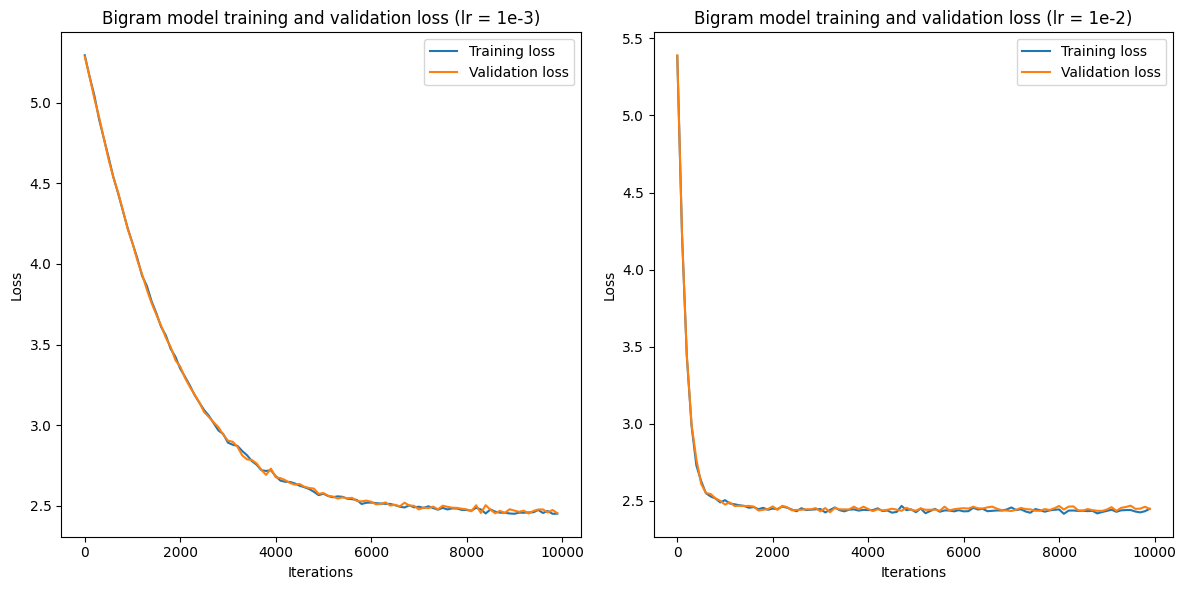

In [22]:
import matplotlib.pyplot as plt

train_losses, val_losses, steps = train_model(model=model)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(steps, train_losses, label="Training loss")
ax1.plot(steps, val_losses, label="Validation loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("Bigram model training and validation loss (lr = 1e-3)")
ax1.legend()

m = BigramModel(vocabulary_size)

model = m.to(device)

train_losses, val_losses, steps = train_model(learning_rate=1e-2, model=model)

ax2.plot(steps, train_losses, label="Training loss")
ax2.plot(steps, val_losses, label="Validation loss")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("Bigram model training and validation loss (lr = 1e-2)")
ax2.legend()
plt.tight_layout()
plt.show()

In [23]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = model.generate(idx, max_new_tokens=300)[0].tolist()

print(decode(generated))

	— прт ияте це Вълаталучеме нканяда на дран о. ние потяно сни в е, и прзпручерат бя опо да датожисеща мевскойкайна сказко; та, спогоги Попрос медай“ ватона Спъм ли бла ръжва ра игоо ра веси ва Ти на о смововакакромочколкра спо — споет кавалури дена се да векогнай к беняше по у га; пока, и а Нол, на р


# Self-attention

Current tokens should get information only from previous tokens (not future ones)

Inefficient way of computing

In [24]:
import torch

batch, time, channel = 4, 8, 2
x = torch.randn(batch, time, channel)
x.shape

torch.Size([4, 8, 2])

In [25]:
 # x[b, t] = mean_{i <= t} x[b, i]
 
x_bag_of_words = torch.zeros(batch, time, channel)

for b in range(batch):
    for t in range(time):
        x_previous = x[b, :t+1] # (time, channel)
        x_bag_of_words[b, t] = torch.mean(x_previous, 0)
        
# x[0] equals x_bag_of_words[0] but x[1] does not equal x_bag_of_words[1]
# because x_bag_of_words[1] is the average of [x0] and x[1]

In [26]:
x[0]

tensor([[ 0.2498, -1.6806],
        [-0.4789, -0.1754],
        [ 0.4035, -1.6914],
        [ 1.0354, -0.2637],
        [-0.2237,  0.4041],
        [ 2.2575,  0.1742],
        [ 0.6847, -1.4273],
        [ 0.4784, -2.3165]])

In [27]:
x_bag_of_words[0]

tensor([[ 0.2498, -1.6806],
        [-0.1145, -0.9280],
        [ 0.0582, -1.1825],
        [ 0.3025, -0.9528],
        [ 0.1972, -0.6814],
        [ 0.5406, -0.5388],
        [ 0.5612, -0.6657],
        [ 0.5508, -0.8721]])

Computing using matrix multiplication (weighted aggregation)

In [28]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) # [[1., 0., 0.], [1., 1., 0.], [1., 1., 1.]]
a = a / torch.sum(a, 1, keepdim=True) # dividing by [[1.], [2.], [3.]], a becomes [[1., 0., 0.], [0.5, 0.5, 0.], [0.33, 0.33, 0.33]]
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# again each row in C is the average of the previous

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [29]:
weighted_aggregation = torch.tril(torch.ones(time, time))
weighted_aggregation = weighted_aggregation / weighted_aggregation.sum(1, keepdim=True)

x_bag_of_words_wei = weighted_aggregation @ x # (batch, time, time) @ (batch, time, channel) ----> (batch, time, channel)
torch.allclose(x_bag_of_words, x_bag_of_words_wei)

True

Computing using softmax (normalization)

In [30]:
import torch.nn.functional as F

tril = torch.tril(torch.ones(time, time))
weighted_aggregation = torch.zeros((time, time))
weighted_aggregation = weighted_aggregation.masked_fill(tril == 0, float('-inf')) # make all 0 tril elements = -inf so softmax returns 0 for them (because shouldn't get information from past tokens)
weighted_aggregation = F.softmax(weighted_aggregation, dim=-1) # normalization
x_bag_of_words_softmax = weighted_aggregation @ x # aggregation
torch.allclose(x_bag_of_words, x_bag_of_words_softmax)

True

# Generative pretrained transformer

In [31]:
class Head(nn.Module):
    def __init__(self, head_size, n_embeddings, context_length):
        super().__init__()
        self.key = nn.Linear(n_embeddings, head_size, bias=False)
        self.query = nn.Linear(n_embeddings, head_size, bias=False)
        self.value = nn.Linear(n_embeddings, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))
    def forward(self, x):
        batch_size, context_length, channel = x.shape
        k = self.key(x) # (batch_size, context_length, channel)
        q = self.query(x) # (batch_size, context_length, channel)
        # attention scores ("affinities")
        weighted_aggregation = q @ k.transpose(-2,-1) * channel**-0.5 # (batch_size, context_length, channel) @ (batch_size, channel, context_length) -> (batch_size, context_length, context_length)
        weighted_aggregation = weighted_aggregation.masked_fill(self.tril[:context_length, :context_length] == 0, float('-inf')) # (batch_size, context_length, context_length)
        weighted_aggregation = F.softmax(weighted_aggregation, dim=-1) # (batch_size, context_length, context_length)
        # weighted aggregation of the values
        v = self.value(x) # (batch_size, context_length, channel)
        return weighted_aggregation @ v # (batch_size, context_length, context_length) @  (batch_size, context_length, channel) ->  (batch_size, context_length, channel)

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embeddings, context_length):
        super(
            ).__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embeddings, context_length) for _ in range(num_heads)])
        self.projection = nn.Linear(n_embeddings, n_embeddings)

    def forward(self, x):
        return self.projection(torch.cat([h(x) for h in self.heads], dim=-1))

In [33]:
class FeedForward(nn.Module):
    def __init__(self, n_embeddings):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_embeddings, 4 * n_embeddings),
            nn.ReLU(),
            nn.Linear(4 * n_embeddings, n_embeddings)
        )
        
        
    def forward(self, x):
        return self.network(x)

In [34]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, n_embeddings, n_heads, context_length):
        super().__init__()
        head_size = n_embeddings // n_heads
        self.self_attention = MultiHeadAttention(n_heads, head_size, n_embeddings, context_length)
        self.feed_forward = FeedForward(n_embeddings)
        self.layer_normalization_self_attention = nn.LayerNorm(n_embeddings)
        self.layer_normalization_feed_forward = nn.LayerNorm(n_embeddings)
        
        
    def forward(self, x):
        x = x + self.self_attention(self.layer_normalization_self_attention(x))
        return x + self.feed_forward(self.layer_normalization_feed_forward(x))

In [35]:
import torch.nn.functional as F

vocabulary_size = len(sorted_chars) # unique chars in dataset
n_embeddings = 32
n_heads = 4

class GPT(nn.Module):
    def __init__(self, vocabulary_size, n_embeddings, n_heads, context_length):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, n_embeddings)
        self.position_embedding_table = nn.Embedding(context_length, n_embeddings) # positions at which the tokens occur
        self.blocks = nn.Sequential(
            Block(n_embeddings, n_heads, context_length),
            Block(n_embeddings, n_heads, context_length),
            Block(n_embeddings, n_heads, context_length)
            nn.LayerNorm(n_embeddings),
        )
        self.lm_head = nn.Linear(n_embeddings, vocabulary_size)
        
    def forward(self, idx, targets=None):
        batch_size, context_length = idx.shape
        
        token_embedding = self.token_embedding_table(idx) # returns (batch, time, channel) = (batch_size, context_length, vocabulary_size)
        position_embedding = self.position_embedding_table(torch.arange(context_length, device=device)) # (context_size, channel)
        x = token_embedding + position_embedding # (batch_size, context_length, channel) - information for both tokens' identities and their positions                                                   
        x = self.blocks(x)
        logits = self.lm_head(x) # (batch, context_length, vocabulary_size)
        
        if targets is None:
            loss = None
        else:        
            batch, time, channel = logits.shape
            
            logits = logits.view(batch * time, channel)
            targets = targets.view(batch * time)
            
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (batch_size, context_length) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:] # crop context
            
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # becomes (batch_size, channel)

            probs = F.softmax(logits, dim=-1) # (batch_size, channel)
            
            next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
            idx = torch.cat((idx, next_idx), dim=1) # (batch_size, context_length + 1)
        return idx

In [36]:
m = GPT(vocabulary_size, n_embeddings, n_heads, context_length)

model = m.to(device)

learning_rate = 1e-3

train_losses, val_losses, steps = train_model(model=model, learning_rate=learning_rate)

step 0: train loss 5.1699, val loss 5.1639
step 100: train loss 2.7511, val loss 2.7406
step 200: train loss 2.5990, val loss 2.5622
step 300: train loss 2.5267, val loss 2.5380
step 400: train loss 2.4794, val loss 2.4328
step 500: train loss 2.4126, val loss 2.4149
step 600: train loss 2.3907, val loss 2.3799
step 700: train loss 2.3269, val loss 2.3534
step 800: train loss 2.3440, val loss 2.3256
step 900: train loss 2.3115, val loss 2.3219
step 1000: train loss 2.2944, val loss 2.3295
step 1100: train loss 2.2715, val loss 2.2777
step 1200: train loss 2.2696, val loss 2.2714
step 1300: train loss 2.2735, val loss 2.2758
step 1400: train loss 2.2589, val loss 2.2532
step 1500: train loss 2.2383, val loss 2.2373
step 1600: train loss 2.2187, val loss 2.2151
step 1700: train loss 2.2125, val loss 2.2325
step 1800: train loss 2.2081, val loss 2.1996
step 1900: train loss 2.2284, val loss 2.2157
step 2000: train loss 2.1947, val loss 2.2087
step 2100: train loss 2.1621, val loss 2.1804


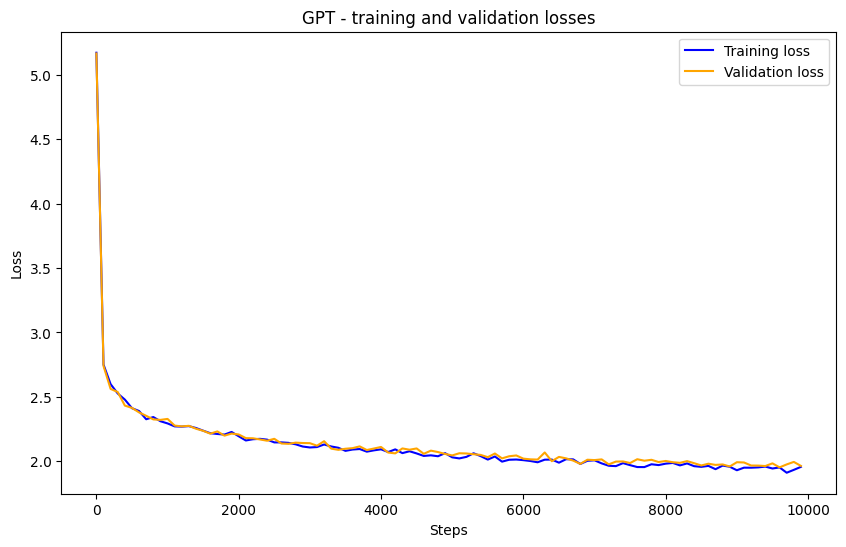

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Training loss', color='blue')
plt.plot(steps, val_losses, label='Validation loss', color='orange')
plt.title('GPT - training and validation losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

	Спомаше празчудно слене ми, която е съдън ще сще ращилите как не бяха щях заобразешем бе е прочневесни Елизавлените от й ще съзнабертво късту истинскилне ми мласите и скресючните мен втряпенат лъцете да на не ме ин предкивотешната обичаше на — в пълваревам беше на мълка, и бил слушата — в чуление.
	Мравързахавентя доближа чужнотие в влекван се да вижните ва занивят и думията ми можеличангелката се прикол от ите убили. Адното тавака накуск, треопитвана любурна казглад — дъки; доъпи трябвата тукс,
